# Case_study_4_2

This notebook analyses experimentally the learning curves and error surface for a regularized logistic function:

$$\mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} \log(1+\exp{(-y_i {\bf{w}}^T{\bf{x}}_i)}) + \lambda\|{\bf{w}}\|_2^2$$

Defining the sigmoid function as $g(u) = 1/(1 + \exp(-u))$, the gradient of $\mathcal{L}(\cdot)$ is:

$$\nabla \mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} -y_i{\bf{x}}_i g(-y_i {\bf{w}}^T{\bf{x}}_i) + \lambda{\bf{w}}$$

and its Hessian:

$$\nabla^2 \mathcal{L}({\bf{w}}) = \frac{1}{n}\sum_{i=1}^{n} {\bf{x}}_i{\bf{x}}_i^T g(-y_i {\bf{w}}^T{\bf{x}}_i)^2 + \lambda {\bf{I}}$$

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_classification
from local.lib.utils import solver_cvx, grad_FOM, grad_SOM, grad_inst, calculation_Hessian_logistic, eval_loss, plot_surface
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install cvxpy

In [ ]:
import cvxpy as cp

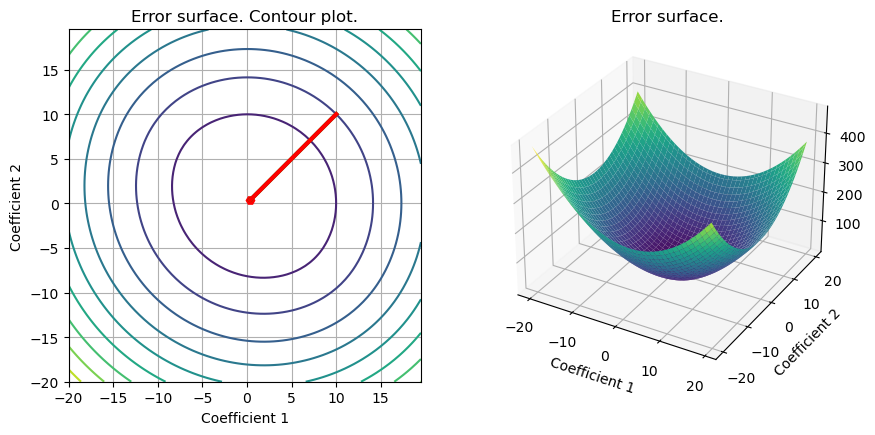

In [2]:
# Loading scenarios
# ===========================
scenario=1
data_class, set_up=scenarios_classification(scenario)

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.logistic(cp.multiply(-Y,(X @ w))))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_logistic_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

grad_logistic_L2 =  lambda n, X, Y, w, lambd: ((1/n)*np.sum((np.diag(-Y.flatten())@X)/np.kron(1+np.exp(np.diag(Y.flatten())@(X@w.reshape(-1,1))),np.ones((1,len(w)))),axis=0).T + lambd*w)
hess_logistic_L2 = calculation_Hessian_logistic
grad_logistic_L2_inst = lambda n, X, Y, w, lambd: (-(Y*X.T)/(1+np.exp(Y*(X@w.reshape(-1,1))))+lambd*w)


# Solution of the empirical risk using CVX
#=========================================
w_L2_cvx=solver_cvx(set_up,loss_logistic_L2)

w = cp.Variable(w_L2_cvx.shape[0])
w.value = w_L2_cvx                                               
loss_opt=loss_logistic_L2(set_up['Niter_train'],set_up['Xtrain'][:,0:set_up['d']+1],set_up['ytrain'][:,0],w_L2_cvx,set_up['Lambda']).value

# Gradient descent
out_gd =grad_FOM(set_up,grad_logistic_L2)

# Newton algorithm
out_hess =grad_SOM(set_up,grad_logistic_L2,hess_logistic_L2)
                                       
S =plot_surface(set_up,loss_logistic_L2,w_L2_cvx, include_grad=True,grad=np.array([out_gd,out_hess]),color=['green','red'])
loss_grad=eval_loss(out_gd,set_up,loss_logistic_L2)

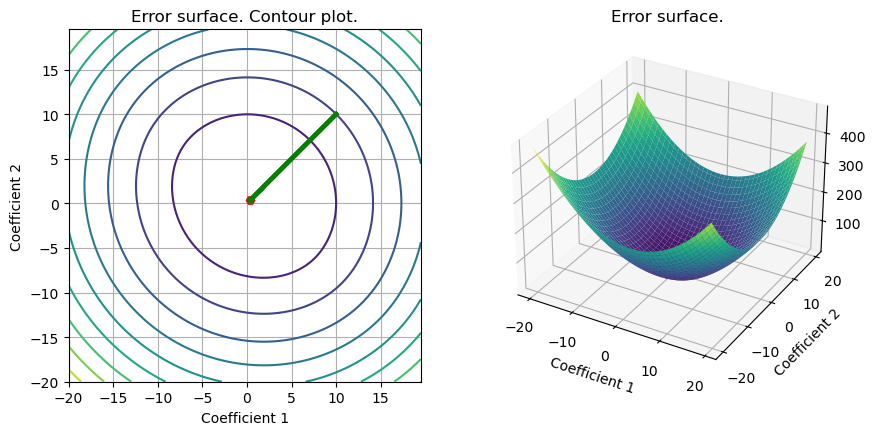

In [3]:
loss_hess=eval_loss(out_hess,set_up,loss_logistic_L2);

# Stochastic gradient descent
# Stochastic gradient descent (several realizations). Comparison with GD and Newton.
loss_inst=np.zeros((set_up['Number_tests'],set_up['Niter_train']))
out_inst_g = np.zeros((set_up['Number_tests']+2,set_up['d']+1,set_up['Niter_train']))
out_inst_g[0,:] = out_hess
out_inst_g[1,:] = out_gd
for kk in range(2,set_up['Number_tests']+2):
    out_inst=grad_inst(set_up,grad_logistic_L2_inst,kk-2);
    out_inst_g[kk,:] = out_inst
    loss_inst[kk-2,:]=eval_loss(out_inst,set_up,loss_logistic_L2);

S = plot_surface(set_up,loss_logistic_L2,w_L2_cvx,include_grad=True,grad=out_inst_g,color = ['red']+['green']*(set_up['Number_tests'] + 1));    

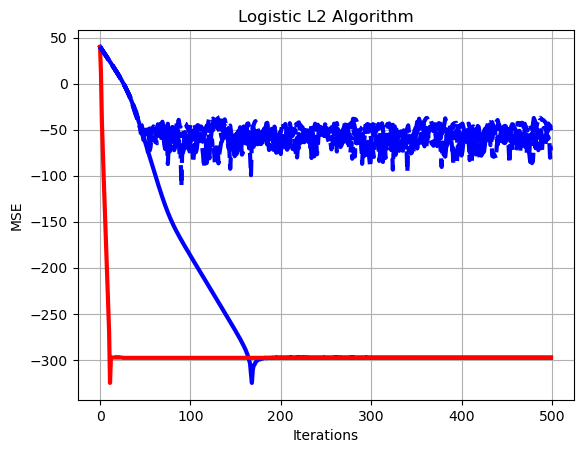

In [4]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
for k in range(set_up['Number_tests']):
    plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_inst[k,:]-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),linestyle='dashed',color='b', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.title('Logistic L2 Algorithm')
plt.show()

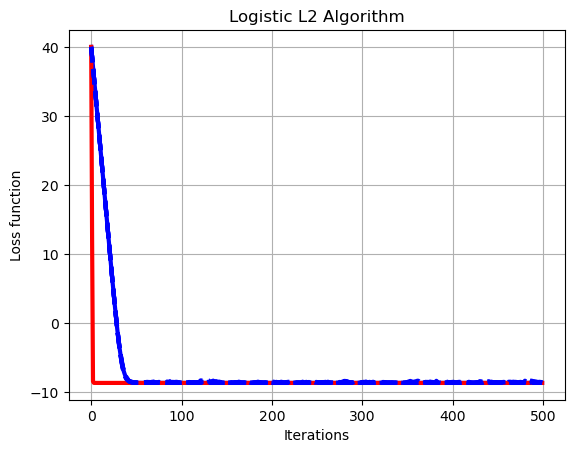

In [5]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_grad-0*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3)
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_hess-0*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3)
for k in range(set_up['Number_tests']):
    plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_inst[k,:]-0*np.ones((1,set_up['Niter_train'])))**2,axis=0)),linestyle='dashed',color='b', linewidth = 3),
plt.xlabel('Iterations')
plt.ylabel('Loss function')
plt.grid()
plt.title('Logistic L2 Algorithm')
plt.show()